# Experiments with Python code in Doc2Vec

In [82]:
import multiprocessing
from pathlib import Path
import ast
import astor
import tokenize
import io

import gensim.models.doc2vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


In [83]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [84]:
def split_methods(code):
    """Parse Python files into separate methods

        :param code: Python code to parse.
        :rtype: map
    """
    funcs = []
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                func = astor.to_source(node)
                funcs.append(func)
    except:
        pass

    if not funcs:
        funcs = code  # just send everything back
    return funcs

In [85]:
def read_train_corpus():
    count = 0
    for i, file in enumerate(test_code_dir.glob('./Python/**/*.py')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenize.generate_tokens(io.StringIO(method).readline))
                    tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                    if tokens:
                        tag = "Method_%s" % count
                        count += 1
                        yield TaggedDocument(tokens, [tag])
                        
            except tokenize.TokenError as te:
                # print("%s: %s" % (type(te).__name__, te.args))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
     
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 100000:
            break


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 0 records


CPU times: user 652 ms, sys: 80.1 ms, total: 732 ms
Wall time: 832 ms
Training corpus size: 15686


In [86]:
%time 
model = Doc2Vec(vector_size=100,
                epochs=15,
                window=8,
                min_count=2,  
                workers=multiprocessing.cpu_count())
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [87]:
model.wv.most_similar('i')

[('+', 0.9931237101554871),
 ('-', 0.9897299408912659),
 ('a', 0.9740518927574158),
 (']', 0.9712302088737488),
 ('j', 0.9705577492713928),
 ('[', 0.9699177742004395),
 ('yield', 0.9615671038627625),
 ('buf', 0.9586920142173767),
 ('down', 0.9572232961654663),
 ('is_prime', 0.9522073864936829)]

In [88]:
model.wv.most_similar('count')

[('re2', 0.9985618591308594),
 ('dimension', 0.99842369556427),
 ('KERNEL_ODD', 0.9981242418289185),
 ('remove', 0.9980157613754272),
 ('prev', 0.997758686542511),
 ('whatsleft', 0.9977555274963379),
 ('HALFWAY', 0.997624933719635),
 ('<<', 0.9974890947341919),
 ('char', 0.9968373775482178),
 ('x_1', 0.9967173933982849)]

In [89]:
def read_test_corpus():
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            yield TaggedDocument(tokens, [implementation.name, programming_language.name])
                    except Exception as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                
                
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 659


In [90]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words)} for doc in test_corpus]

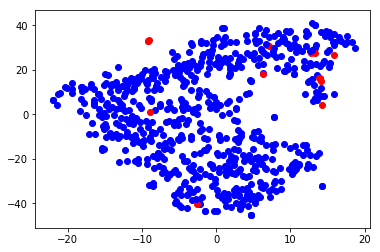

In [91]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
fiftyDimVecs = pca.fit_transform([doc['vec'] for doc in docs])
tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform(fiftyDimVecs)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=('r' if doc['name'].startswith('sieve') else 'b'))
plt.show()